# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

#### Maximize the rate of return on advertising expenditures and target each customer with the right ads with the right channels. We also want to take a further look at the groupings of customers to figure out what features are important enough to group different users. 

* How offer types vary from each other based on different pairs of features?
* Check out users distribution based on different features
* Check out offer distributions based on different offer actions 
* Check out the distribution of users who have consumed offers
* To see if users can be classified by offer ID
* To see if users can be classified by offer Type


In [433]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [434]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

from pathlib import Path

## 1. Data Processing & Data Exploration

In [435]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [436]:
len(portfolio)

10

In [437]:
offer_types = portfolio['offer_type'].unique()
offer_types

array(['bogo', 'informational', 'discount'], dtype=object)

In [438]:
temp_df = portfolio[['duration', 'reward', 'difficulty', 'offer_type']]
bogo_df = temp_df[temp_df['offer_type'] == 'bogo']
info_df = temp_df[temp_df['offer_type'] == 'informational']
discount_df = temp_df[temp_df['offer_type'] == 'discount']


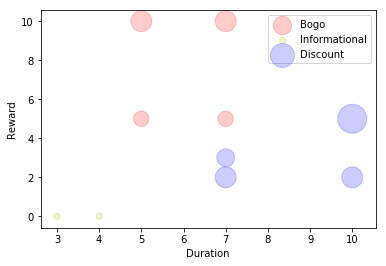

In [439]:
plt.scatter(bogo_df['duration'], bogo_df['reward'], s=40* (bogo_df['difficulty'] + 1) ,color='r', alpha=0.2, label='Bogo')
plt.scatter(info_df['duration'], info_df['reward'], s=40* (info_df['difficulty'] + 1) ,color='y', alpha=0.2, label='Informational')
plt.scatter(discount_df['duration'], discount_df['reward'], s=40* (discount_df['difficulty'] + 1) ,color='b', alpha=0.2, label='Discount')

plt.xlabel('Duration')
plt.ylabel('Reward')

plt.legend()

In [440]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [441]:
# Convert age 118 to np.nan
profile['age'] = profile['age'].apply(lambda a: np.nan if a == 118 else a)

now = datetime.datetime.today().date()
profile['membership'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d').apply(lambda t: (now-t.date()).days)
profile.drop(['became_member_on'], axis=1, inplace=True)

profile['gender'] = profile['gender'].apply(lambda g: np.nan if g == None else g)

In [442]:
profile.head()

,age,gender,id,income,membership
0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1106
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,953
2,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,591
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1020
4,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,933


In [443]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


Text(0,0.5,'Count')

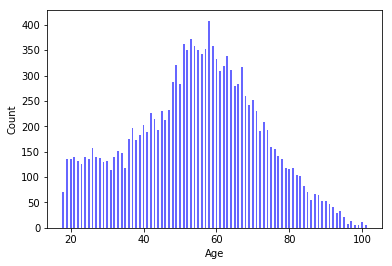

In [444]:
age_vc = profile['age'].value_counts()
plt.bar(age_vc.index, age_vc, 0.5, alpha=0.6, color='b')
plt.xlabel('Age')
plt.ylabel('Count')

In [445]:
evetn_vc = transcript['event'].value_counts()

<Container object of 4 artists>

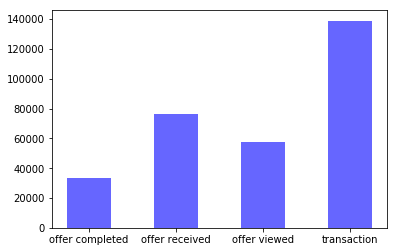

In [446]:
plt.bar(evetn_vc.index, evetn_vc, 0.5, alpha=0.6, color='b')

In [447]:

transcript['offer_id'] = transcript['value'].apply(lambda x: x if ('offer id' in x) or ('offer_id' in x) else np.nan)
print(len(transcript[transcript['offer_id'].isnull()]))

transcript['offer_id']


138953


0          {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2          {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3          {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4          {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5          {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6          {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7          {'offer id': '3f207df678b143eea3cee63160fa8bed'}
8          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9          {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
10         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
11         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
12         {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
13         {'offer id': '3f207df678b143eea3cee63160fa8bed'}
14         {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15         {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
16         {'offer id': '0b1e1539f2cc45b

In [448]:
def convert_offer_id(x):
    if pd.isnull(x):
        return x
    elif 'offer id' in x:
        return x['offer id']
    elif 'offer_id' in x:
        return x['offer_id']
        

transcript['offer_id'] = transcript['offer_id'].apply(convert_offer_id)

In [449]:
pf_tran_merg_df = pd.merge(portfolio, transcript, left_on='id', right_on='offer_id')

pf_tran_merg_df.head(5)

,channels,difficulty,duration,id,offer_type,reward,event,person,time,value,offer_id
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
1,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,1e9420836d554513ab90eba98552d0a9,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
2,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,02c083884c7d45b39cc68e1314fec56c,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
3,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,676506bad68e4161b9bbaffeb039626b,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
4,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,offer received,fe8264108d5b4f198453bbb1fa7ca6c9,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd


In [450]:
pf_tran_merg_df[pf_tran_merg_df['event'] == 'offer completed']['offer_type'].value_counts()

discount    17910
bogo        15669
Name: offer_type, dtype: int64

In [451]:
pf_tran_merg_df['event'].unique()

array(['offer received', 'offer viewed', 'offer completed'], dtype=object)

In [452]:
tmp_summary_df = pf_tran_merg_df[(pf_tran_merg_df['event'] == 'offer completed') | (pf_tran_merg_df['event'] == 'offer viewed') | (pf_tran_merg_df['event'] == 'offer received')]

In [453]:
tmp_summary_df.drop(['channels', 'difficulty', 'id', 'reward', 'value'], axis=1, inplace=True)

In [454]:
tmp_summary_df.head(15)

,duration,offer_type,event,person,time,offer_id
0,7,bogo,offer received,4b0da7e80e5945209a1fdddfe813dbe0,0,ae264e3637204a6fb9bb56bc8210ddfd
1,7,bogo,offer received,1e9420836d554513ab90eba98552d0a9,0,ae264e3637204a6fb9bb56bc8210ddfd
2,7,bogo,offer received,02c083884c7d45b39cc68e1314fec56c,0,ae264e3637204a6fb9bb56bc8210ddfd
3,7,bogo,offer received,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd
4,7,bogo,offer received,fe8264108d5b4f198453bbb1fa7ca6c9,0,ae264e3637204a6fb9bb56bc8210ddfd
5,7,bogo,offer received,39dbcf43e24d41f4bbf0f134157e0e1e,0,ae264e3637204a6fb9bb56bc8210ddfd
6,7,bogo,offer received,3f244f4dea654688ace14acb4f0257bb,0,ae264e3637204a6fb9bb56bc8210ddfd
7,7,bogo,offer received,1c587de019994f93a242c6864fd7bc55,0,ae264e3637204a6fb9bb56bc8210ddfd
8,7,bogo,offer received,92e07c49ee7448fca6e48df0c96e3eec,0,ae264e3637204a6fb9bb56bc8210ddfd
9,7,bogo,offer received,f8aedd0cbea0419c806842b4265b82e5,0,ae264e3637204a6fb9bb56bc8210ddfd


In [455]:
tmp_summary_df.groupby(['person', 'offer_id']).size()

person                            offer_id                        
0009655768c64bdeb2e877511632db8f  2906b810c7d4411798c6938adc9daaa5    2
                                  3f207df678b143eea3cee63160fa8bed    2
                                  5a8bc65990b245e5a138643cd4eb9837    2
                                  f19421c1d4aa40978ebb69ca19b0e20d    3
                                  fafdcd668e3743c1bb461111dcafc2a4    3
00116118485d4dfda04fdbaba9a87b5c  f19421c1d4aa40978ebb69ca19b0e20d    4
0011e0d4e6b944f998e987f904e8c1e5  0b1e1539f2cc45b7b9fa7c272da2e1d7    3
                                  2298d6c36e964ae4a3e7e9706d1fb8c2    3
                                  3f207df678b143eea3cee63160fa8bed    2
                                  5a8bc65990b245e5a138643cd4eb9837    2
                                  9b98b8c7a33c4b65b9aebfe6a799e6d9    3
0020c2b971eb4e9188eac86d93036a77  4d5c57ea9a6940dd891ad53e9dbe8da0    3
                                  5a8bc65990b245e5a138643cd4eb9837   

In [456]:
tmp_summary_df.groupby(['person', 'offer_id']).first()


duration  \
person                           offer_id                                     
0009655768c64bdeb2e877511632db8f 2906b810c7d4411798c6938adc9daaa5         7   
                                 3f207df678b143eea3cee63160fa8bed         4   
                                 5a8bc65990b245e5a138643cd4eb9837         3   
                                 f19421c1d4aa40978ebb69ca19b0e20d         5   
                                 fafdcd668e3743c1bb461111dcafc2a4        10   
00116118485d4dfda04fdbaba9a87b5c f19421c1d4aa40978ebb69ca19b0e20d         5   
0011e0d4e6b944f998e987f904e8c1e5 0b1e1539f2cc45b7b9fa7c272da2e1d7        10   
                                 2298d6c36e964ae4a3e7e9706d1fb8c2         7   
                                 3f207df678b143eea3cee63160fa8bed         4   
                                 5a8bc65990b245e5a138643cd4eb9837         3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9         7   
0020c2b971eb4e9188eac86d93036a77 4d5c57ea9a6940dd891ad53e9dbe8da0         5   
                                 5a8bc65990b245e5a138643cd4eb9837         3   
                                 ae264e3637204a6fb9bb56bc8210ddfd         7   
                                 fafdcd668e3743c1bb461111dcafc2a4        10   
0020ccbbb6d84e358d3414a3ff76cffd 2298d6c36e964ae4a3e7e9706d1fb8c2         7   
                                 5a8bc65990b245e5a138643cd4eb9837         3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9         7   
                                 f19421c1d4aa40978ebb69ca19b0e20d         5   
003d66b6608740288d6cc97a6903f4f0 0b1e1539f2cc45b7b9fa7c272da2e1d7        10   
                                 3f207df678b143eea3cee63160fa8bed         4   
                                 5a8bc65990b245e5a138643cd4eb9837         3   
                                 fafdcd668e3743c1bb461111dcafc2a4        10   
00426fe3ffde4c6b9cb9ad6d077a13ea 0b1e1539f2cc45b7b9fa7c272da2e1d7        10   
                                 2906b810c7d4411798c6938adc9daaa5         7   
                                 5a8bc65990b245e5a138643cd4eb9837         3   
                                 fafdcd668e3743c1bb461111dcafc2a4        10   
004b041fbfe44859945daa2c7f79ee64 3f207df678b143eea3cee63160fa8bed         4   
                                 f19421c1d4aa40978ebb69ca19b0e20d         5   
                                 fafdcd668e3743c1bb461111dcafc2a4        10   
...                                                                     ...   
ffed75d3abc64b488982f50ed12878b5 4d5c57ea9a6940dd891ad53e9dbe8da0         5   
                                 ae264e3637204a6fb9bb56bc8210ddfd         7   
ffede3b700ac41d6a266fa1ba74b4f16 0b1e1539f2cc45b7b9fa7c272da2e1d7        10   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0         5   
                                 f19421c1d4aa40978ebb69ca19b0e20d         5   
                                 fafdcd668e3743c1bb461111dcafc2a4        10   
fff0f0aac6c547b9b263080f09a5586a 3f207df678b143eea3cee63160fa8bed         4   
                                 4d5c57ea9a6940dd891ad53e9dbe8da0         5   
fff29fb549084123bd046dbc5ceb4faa 4d5c57ea9a6940dd891ad53e9dbe8da0         5   
                                 ae264e3637204a6fb9bb56bc8210ddfd         7   
                                 f19421c1d4aa40978ebb69ca19b0e20d         5   
                                 fafdcd668e3743c1bb461111dcafc2a4        10   
fff3ba4757bd42088c044ca26d73817a 2906b810c7d4411798c6938adc9daaa5         7   
                                 5a8bc65990b245e5a138643cd4eb9837         3   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9         7   
                                 fafdcd668e3743c1bb461111dcafc2a4        10   
fff7576017104bcc8677a8d63322b5e1 4d5c57ea9a6940dd891ad53e9dbe8da0         5   
                                 9b98b8c7a33c4b65b9aebfe6a799e6d9         7   
                                 ae264

In [457]:
# Here we are trying to calcuate the number of offer completed after both offer received and offer viewed happened within the valid duration of the offer
def user_offer_completion_counts(group):
    offer_counts = 0
    prev_offer_completed_index = 0
    latest_offer_received_index = None

    for i in range(len(group)):
        if group.iloc[i]['event'] == 'offer received':
            latest_offer_received_index = i

        if group.iloc[i]['event'] == 'offer completed':
            for j in range(i):
                in_time = latest_offer_received_index != None and int(group.iloc[i]['time']) - int(group.iloc[latest_offer_received_index]['time']) <= (int(group.iloc[i]['duration']) * 24)

                if group.iloc[j]['event'] == 'offer viewed' and j >= prev_offer_completed_index and j > latest_offer_received_index and in_time:
    #                 print(int(tt.iloc[j]['time']))
    #                 print(int(tt.iloc[j]['duration']))
    #                 print(latest_offer_received_index)
    #                 print(i)
                    offer_counts += 1
            prev_offer_completed_index = i
            
    return offer_counts

In [458]:
# t = tmp_summary_df.groupby(['person', 'offer_id'])
# # tt = t.get_group(('004c5799adbf42868b9cff0396190900', 'f19421c1d4aa40978ebb69ca19b0e20d'))
# # tt = t.get_group(('005500a7188546ff8a767329a2f7c76a', 'ae264e3637204a6fb9bb56bc8210ddfd'))
# tt = t.get_group(('00715b6e55c3431cb56ff7307eb19675', '0b1e1539f2cc45b7b9fa7c272da2e1d7'))
# tt

In [459]:
# user_offer_completion_counts(tt)

In [460]:
users_list = profile['id'].unique()
columns = {'Customer': users_list}
for p_id in portfolio['id'].unique():
    columns[p_id] = [0] * len(users_list)
    
model_df = pd.DataFrame(columns)

model_df.set_index('Customer', inplace=True)

model_df.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
Customer,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0,0,0,0,0,0,0,0,0,0
0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,0,0,0,0
38fe809add3b4fcf9315a9694bb96ff5,0,0,0,0,0,0,0,0,0,0
78afa995795e4d85b5d9ceeca43f5fef,0,0,0,0,0,0,0,0,0,0
a03223e636434f42ac4c3df47e8bac43,0,0,0,0,0,0,0,0,0,0


In [461]:
model_df_file = Path("model_df.csv")
if model_df_file.is_file():
    model_df = pd.read_csv('model_df.csv', index_col=False)
else:
    current_processing_index = 0
    for name, group in tmp_summary_df.groupby(['person', 'offer_id']):
        person_id = name[0]
        offer_id = name[1]

        purchase_count = user_offer_completion_counts(group)

    #     if purchase_count != 0:
    #         print(person_id)
    #         print(offer_id)
    #         print(purchase_count)

        model_df.loc[person_id][offer_id] = purchase_count
        current_processing_index += 1
        print(current_processing_index)
    #     if current_processing_index == 50:
    #         break

In [462]:
model_df.head()

,Customer,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0,68be06ca386d4c31939f3a4f0e3dd783,0,0,0,0,0,1,1,0,0,0
1,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,0,0,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,0,0,0,0,0,0,0,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,1,0,0,0,0,0,0
4,a03223e636434f42ac4c3df47e8bac43,0,0,0,0,0,0,0,0,0,0


In [463]:
model_df_file = Path("model_df.csv")
if not model_df_file.is_file():
    model_df.to_csv('model_df.csv', index=False)
    model_df = model_df.reset_index()


In [464]:
model_df.head()

,Customer,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5
0,68be06ca386d4c31939f3a4f0e3dd783,0,0,0,0,0,1,1,0,0,0
1,0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,0,0,0,0
2,38fe809add3b4fcf9315a9694bb96ff5,0,0,0,0,0,0,0,0,0,0
3,78afa995795e4d85b5d9ceeca43f5fef,1,0,0,1,0,0,0,0,0,0
4,a03223e636434f42ac4c3df47e8bac43,0,0,0,0,0,0,0,0,0,0


In [465]:
new_model_df = pd.merge(model_df, profile, left_on='Customer', right_on='id')

In [466]:
new_model_df.set_index('Customer', inplace=True)

In [467]:
new_model_df.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,age,gender,id,income,membership
Customer,,,,,,,,,,,,,,,
68be06ca386d4c31939f3a4f0e3dd783,0,0,0,0,0,1,1,0,0,0,NaN,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN,1106
0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,0,0,0,0,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,953
38fe809add3b4fcf9315a9694bb96ff5,0,0,0,0,0,0,0,0,0,0,NaN,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN,591
78afa995795e4d85b5d9ceeca43f5fef,1,0,0,1,0,0,0,0,0,0,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1020
a03223e636434f42ac4c3df47e8bac43,0,0,0,0,0,0,0,0,0,0,NaN,NaN,a03223e636434f42ac4c3df47e8bac43,NaN,933


In [468]:
new_model_df.to_csv('new_model_df.csv')

In [469]:
len(new_model_df)

17000

In [470]:
trimmed_df = new_model_df.dropna()

In [471]:
trimmed_df.shape
trimmed_df = trimmed_df.drop(['id'], axis=1)
trimmed_df.shape

(14825, 14)

In [472]:
trimmed_df.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,age,gender,income,membership
Customer,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,0,0,0,0,55.0,F,112000.0,953
78afa995795e4d85b5d9ceeca43f5fef,1,0,0,1,0,0,0,0,0,0,75.0,F,100000.0,1020
e2127556f4f64592b11af22de27a7932,0,0,0,1,0,0,1,0,0,0,68.0,M,70000.0,668
389bc3fa690240e798340f5a15918d5c,0,0,0,1,0,0,1,0,2,1,65.0,M,53000.0,744
2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,0,0,1,0,0,0,58.0,M,51000.0,834


In [473]:
new_gender_columns = pd.get_dummies(trimmed_df['gender'])

In [474]:
new_gender_columns.head()

,F,M,O
Customer,,,
0610b486422d4921ae7d2bf64640c50b,1,0,0
78afa995795e4d85b5d9ceeca43f5fef,1,0,0
e2127556f4f64592b11af22de27a7932,0,1,0
389bc3fa690240e798340f5a15918d5c,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,0,1,0


In [475]:
trimmed_df = pd.concat([trimmed_df, new_gender_columns], axis=1, sort=False, ignore_index=False)
trimmed_df.drop(['gender'], axis=1, inplace=True)

In [476]:
trimmed_df.head()

,ae264e3637204a6fb9bb56bc8210ddfd,4d5c57ea9a6940dd891ad53e9dbe8da0,3f207df678b143eea3cee63160fa8bed,9b98b8c7a33c4b65b9aebfe6a799e6d9,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,fafdcd668e3743c1bb461111dcafc2a4,5a8bc65990b245e5a138643cd4eb9837,f19421c1d4aa40978ebb69ca19b0e20d,2906b810c7d4411798c6938adc9daaa5,age,income,membership,F,M,O
Customer,,,,,,,,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0,0,0,0,0,0,0,0,0,0,55.0,112000.0,953,1,0,0
78afa995795e4d85b5d9ceeca43f5fef,1,0,0,1,0,0,0,0,0,0,75.0,100000.0,1020,1,0,0
e2127556f4f64592b11af22de27a7932,0,0,0,1,0,0,1,0,0,0,68.0,70000.0,668,0,1,0
389bc3fa690240e798340f5a15918d5c,0,0,0,1,0,0,1,0,2,1,65.0,53000.0,744,0,1,0
2eeac8d8feae4a8cad5a6af0499a211d,0,0,0,0,0,0,1,0,0,0,58.0,51000.0,834,0,1,0


In [477]:
scaler = MinMaxScaler()
new_model_df = scaler.fit_transform(trimmed_df)

In [478]:

new_model_df = pd.DataFrame(new_model_df)
new_model_df.columns = trimmed_df.columns.values

In [479]:
new_model_df.shape

(14825, 16)

## 2. Feature Reduction - PCA

In [480]:
pca = PCA()
pca.fit(new_model_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

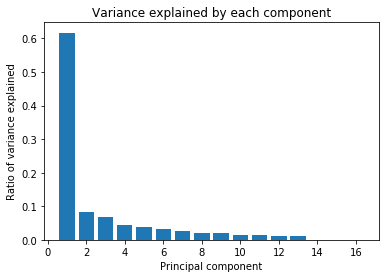

In [481]:
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()


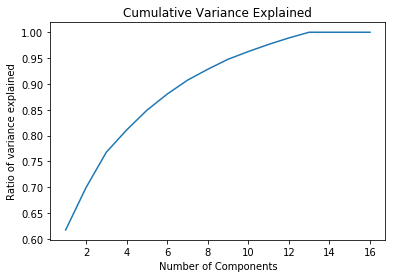

In [482]:
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [483]:
target_cum_var = 0.9
cum_sum = 0
cum_comp = 0
for va in pca.explained_variance_ratio_:
    cum_sum += va
    cum_comp += 1
    if cum_sum > target_cum_var:
        break
        
print("Ideal number of components: {}".format(cum_comp))

Ideal number of components: 7


In [484]:
pca_7 = PCA(n_components=7)
updated_pca_7 = pca_7.fit_transform(new_model_df)

In [485]:
print(updated_pca_7.shape)

(14825, 7)


In [486]:
def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(new_model_df.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [487]:
pca_weights(pca_7, 0)

F                                   7.011592e-01
income                              9.085116e-02
age                                 5.331816e-02
4d5c57ea9a6940dd891ad53e9dbe8da0    1.721311e-02
f19421c1d4aa40978ebb69ca19b0e20d    1.288799e-02
ae264e3637204a6fb9bb56bc8210ddfd    1.215585e-02
fafdcd668e3743c1bb461111dcafc2a4    8.378534e-03
9b98b8c7a33c4b65b9aebfe6a799e6d9    7.305681e-03
2298d6c36e964ae4a3e7e9706d1fb8c2    5.901612e-03
0b1e1539f2cc45b7b9fa7c272da2e1d7    5.729635e-03
2906b810c7d4411798c6938adc9daaa5    4.156310e-03
O                                   3.401418e-03
3f207df678b143eea3cee63160fa8bed    0.000000e+00
5a8bc65990b245e5a138643cd4eb9837   -4.135903e-25
membership                         -6.572572e-03
M                                  -7.045606e-01
Name: 0, dtype: float64

In [488]:
pca_weights(pca_7, 1)

income                              7.968565e-01
age                                 5.167983e-01
membership                          2.506496e-01
fafdcd668e3743c1bb461111dcafc2a4    8.668250e-02
f19421c1d4aa40978ebb69ca19b0e20d    8.132421e-02
M                                   7.791351e-02
4d5c57ea9a6940dd891ad53e9dbe8da0    6.204292e-02
9b98b8c7a33c4b65b9aebfe6a799e6d9    4.631678e-02
ae264e3637204a6fb9bb56bc8210ddfd    3.480268e-02
2298d6c36e964ae4a3e7e9706d1fb8c2    3.182703e-02
0b1e1539f2cc45b7b9fa7c272da2e1d7    3.173302e-02
2906b810c7d4411798c6938adc9daaa5    3.164036e-02
5a8bc65990b245e5a138643cd4eb9837    8.673617e-19
3f207df678b143eea3cee63160fa8bed   -2.220446e-16
O                                  -1.019980e-02
F                                  -6.771371e-02
Name: 1, dtype: float64

## 3. Model Training

In [489]:
def k_means_score(data, n_cluster):
    kmeans = KMeans(n_clusters = n_cluster)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

## 4. Model Evaluation

In [490]:
# Over a number of different cluster counts...
scores = []
group_counts = list(range(1,11))
for i in group_counts:
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    scores.append(k_means_score(updated_pca_7, i))

Text(0,0.5,'SSE')

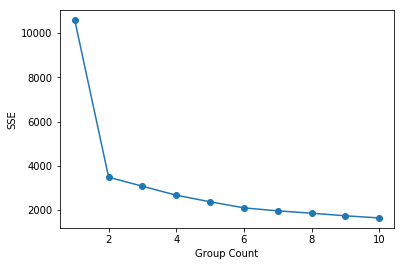

In [491]:
plt.plot(group_counts, scores, linestyle='-', marker='o')
plt.xlabel('Group Count')
plt.ylabel('SSE')

In [492]:
# Here we chose 2 componentes as that is where the elbow locates in the graph above
kmeans = KMeans(n_clusters = 2)
model_2 = kmeans.fit(updated_pca_7)
updated_pca_7_pred = model_2.predict(updated_pca_7)

In [493]:
print(updated_pca_7_pred[:100])

[1 1 0 0 0 1 0 1 0 0 1 1 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1
 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0
 1 0 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1]


## 5. Findings

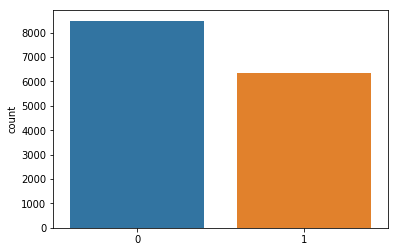

In [494]:
sns.countplot(updated_pca_7_pred)

In [495]:
centroid_1 = scaler.inverse_transform(pca_7.inverse_transform(model_2.cluster_centers_[0]).reshape(1, -1))

In [496]:
new_model_df.columns

Index(['ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '3f207df678b143eea3cee63160fa8bed', '9b98b8c7a33c4b65b9aebfe6a799e6d9',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2',
       'fafdcd668e3743c1bb461111dcafc2a4', '5a8bc65990b245e5a138643cd4eb9837',
       'f19421c1d4aa40978ebb69ca19b0e20d', '2906b810c7d4411798c6938adc9daaa5',
       'age', 'income', 'membership', 'F', 'M', 'O'],
      dtype='object')

In [497]:
c1 = pd.Series(data = centroid_1.squeeze(), index = new_model_df.columns)
c1

ae264e3637204a6fb9bb56bc8210ddfd    1.435250e-01
4d5c57ea9a6940dd891ad53e9dbe8da0    1.438409e-01
3f207df678b143eea3cee63160fa8bed   -6.406646e-19
9b98b8c7a33c4b65b9aebfe6a799e6d9    1.197917e-01
0b1e1539f2cc45b7b9fa7c272da2e1d7    7.504973e-02
2298d6c36e964ae4a3e7e9706d1fb8c2    2.629315e-01
fafdcd668e3743c1bb461111dcafc2a4    2.763685e-01
5a8bc65990b245e5a138643cd4eb9837   -3.219482e-18
f19421c1d4aa40978ebb69ca19b0e20d    2.043699e-01
2906b810c7d4411798c6938adc9daaa5    1.257101e-01
age                                 5.209917e+01
income                              6.117893e+04
membership                          1.107223e+03
F                                  -5.324307e-05
M                                   9.991080e-01
O                                   9.452002e-04
dtype: float64

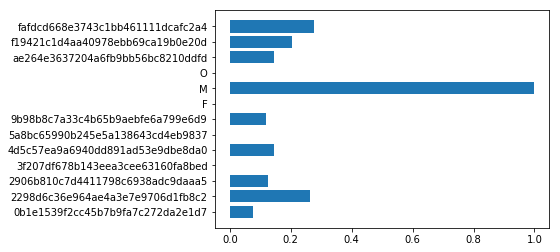

In [498]:
t1 = c1[['F','M','O','ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0', '3f207df678b143eea3cee63160fa8bed', '9b98b8c7a33c4b65b9aebfe6a799e6d9', '0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2', 'fafdcd668e3743c1bb461111dcafc2a4', '5a8bc65990b245e5a138643cd4eb9837', 'f19421c1d4aa40978ebb69ca19b0e20d', '2906b810c7d4411798c6938adc9daaa5']]


fig, ax = plt.subplots()
ax.barh(t1.index.values, t1.values, align='center')
ax.set_yticks(t1.index.values)
ax.set_yticklabels(t1.index.values)

plt.show()

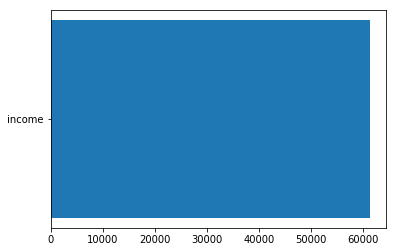

In [499]:
t2 = c1[['income']]


fig, ax = plt.subplots()
ax.barh(t2.index.values, t2.values, align='center')
ax.set_yticks(t2.index.values)
ax.set_yticklabels(t2.index.values)

plt.show()

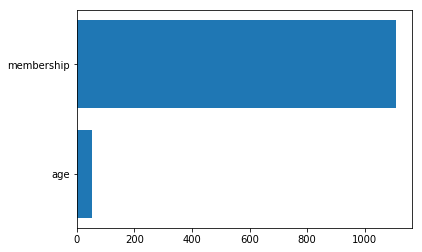

In [500]:
t3 = c1[['age','membership']]


fig, ax = plt.subplots()
ax.barh(t3.index.values, t3.values, align='center')
ax.set_yticks(t3.index.values)
ax.set_yticklabels(t3.index.values)

plt.show()

In [501]:
centroid_2 = scaler.inverse_transform(pca_7.inverse_transform(model_2.cluster_centers_[1]).reshape(1, -1))
c2 = pd.Series(data = centroid_2.squeeze(), index = new_model_df.columns)
c2

ae264e3637204a6fb9bb56bc8210ddfd    2.108193e-01
4d5c57ea9a6940dd891ad53e9dbe8da0    2.364456e-01
3f207df678b143eea3cee63160fa8bed    8.588386e-19
9b98b8c7a33c4b65b9aebfe6a799e6d9    1.583278e-01
0b1e1539f2cc45b7b9fa7c272da2e1d7    1.021081e-01
2298d6c36e964ae4a3e7e9706d1fb8c2    2.943556e-01
fafdcd668e3743c1bb461111dcafc2a4    3.080763e-01
5a8bc65990b245e5a138643cd4eb9837    4.315854e-18
f19421c1d4aa40978ebb69ca19b0e20d    2.555565e-01
2906b810c7d4411798c6938adc9daaa5    1.508677e-01
age                                 5.746920e+01
income                              7.107021e+04
membership                          1.089097e+03
F                                   9.677064e-01
M                                   9.056021e-05
O                                   3.220308e-02
dtype: float64

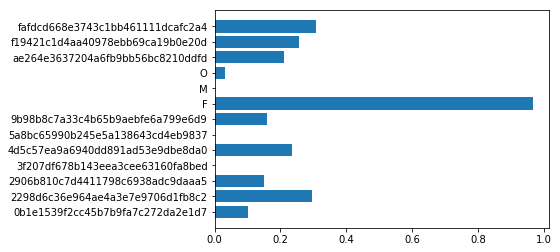

In [502]:
t4 = c2[['F','M','O','ae264e3637204a6fb9bb56bc8210ddfd', '4d5c57ea9a6940dd891ad53e9dbe8da0', '3f207df678b143eea3cee63160fa8bed', '9b98b8c7a33c4b65b9aebfe6a799e6d9', '0b1e1539f2cc45b7b9fa7c272da2e1d7', '2298d6c36e964ae4a3e7e9706d1fb8c2', 'fafdcd668e3743c1bb461111dcafc2a4', '5a8bc65990b245e5a138643cd4eb9837', 'f19421c1d4aa40978ebb69ca19b0e20d', '2906b810c7d4411798c6938adc9daaa5']]

fig, ax = plt.subplots()
ax.barh(t4.index.values, t4.values, align='center')
ax.set_yticks(t4.index.values)
ax.set_yticklabels(t4.index.values)

plt.show()

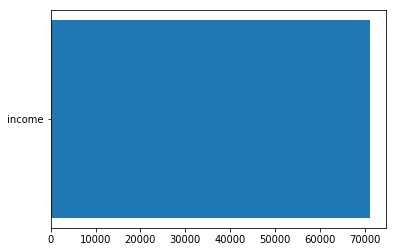

In [503]:
t5 = c2[['income']]


fig, ax = plt.subplots()
ax.barh(t5.index.values, t5.values, align='center')
ax.set_yticks(t5.index.values)
ax.set_yticklabels(t5.index.values)

plt.show()

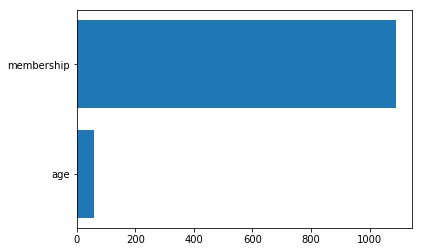

In [504]:
t6 = c2[['age','membership']]


fig, ax = plt.subplots()
ax.barh(t6.index.values, t6.values, align='center')
ax.set_yticks(t6.index.values)
ax.set_yticklabels(t6.index.values)

plt.show()

## 6. Conclusions

From the SSE analysis above, we found out that all our data points can be mainly categorized into two clusters. Further taking a look into 
the composition of each cluster, we found out the sole feature that distinguishs the two clusters is gender. Other than the feature - gender,
other features basically have the similar impacts on the data points distribution. 
In addition to that, we also found out that the two clusters actually share similar patterns in terms of the preferred offers thay received.
The top 3 offers both groups share are **fafdcd668e3743c1bb461111dcafc2a4**, **f19421c1d4aa40978ebb69ca19b0e20d**, **2298d6c36e964ae4a3e7e9706d1fb8c2**. 

* 1. fafdcd668e3743c1bb461111dcafc2a4 (discount)
* 2. f19421c1d4aa40978ebb69ca19b0e20d (bogo)
* 3. 2298d6c36e964ae4a3e7e9706d1fb8c2 (discount)

From the these offers, we can find out that the preferred channels the customers use to access the offer info are: 
**web**, **email**, **mobile**, **social**